In [30]:
import gym
import random
from keras import Sequential
# import tensorflow as tf
from collections import deque
from keras.layers import Dense
from keras.optimizers import adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear
import psutil
import gc

import numpy as np

In [31]:
env = gym.make('LunarLander-v2')
# Landing pad is always at coordinates (0,0). 
# Coordinates are the first two numbers in state vector. 
# Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. 
# If lander moves away from landing pad it loses reward back. 
# Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. 
# Each leg ground contact is +10. 
# Firing main engine is -0.3 points each frame. Solved is 200 points. 
# Landing outside landing pad is possible. 
# Fuel is infinite, so an agent can learn to fly and then land on its first attempt. 
# Four discrete actions available: do nothing, fire left orientation engine, fire main engine,
#     fire right orientation engine.

print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)
state_size = env.observation_space.shape[0]

Box(8,)
[inf inf inf inf inf inf inf inf]
[-inf -inf -inf -inf -inf -inf -inf -inf]


In [32]:
# # neural network architecture, input=states, output=actions
def build_model(input_size, output_size,lr = 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim = input_size, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(output_size, activation = "linear"))
    model.compile(loss='mse', optimizer=adam(lr=lr))
    return model

![Explanation of environment exploration/exploitation] (https://github.com/VeronikaRevjakina/LunaLander_RL/blob/master/firefox_mQVLhQrl3o.png?raw=true)

[QL](https://www.freecodecamp.org/news/diving-deeper-into-reinforcement-learning-with-q-learning-c18d0db58efe)

In [39]:
def dql_train(env, state_size, action_size, model, train_games_num, max_steps_in_game,batch_size,discount_rate,
              epsilon=1.0,epsilon_decay = 0.99):
    counter = 0
    scores = np.array([])
    #object for remembering all things need for dql in memory
    memory = {"state":np.array([]), 
            "action":np.array([], dtype = int), 
            "reward":np.array([]),
            "new_state":np.array([]), 
            "done":np.array([])
            }
    for game in range(train_games_num):
        obs = env.reset() #to initial state
#         obs = obs.reshape([1,state_size]) # reshape for neural network input
        obs = np.reshape(obs, (1, state_size))
#         np.reshape(obs, (1, state_size))
#         obs = np.reshape(obs, (1, state_size))
        game_score = 0
        
        for step in range(max_steps_in_game):  
            # get an action number random or model
            if np.random.rand() <= epsilon:
                action =int(random.randrange(action_size))  # get random because explore env
            else:
#                 act_values = model(obs) # model predict based on state
#                 action = int(np.argmax(act_values[0]))
                action = np.argmax(model.predict(obs)[0])
#             env.render()
            # take an action
            new_obs, reward, done, info = env.step(action)
#             new_obs = new_obs.reshape([1,state_size]) # reshape for neural network input
            new_obs = np.reshape(new_obs, (1, state_size))
            game_score += reward
        
            #  remember into memory this step
            if len(memory["state"])>0:
                memory["state"] = np.vstack((memory["state"], obs)) # to get matrix of row = state vector of 8 values
                memory["new_state"] = np.vstack((memory["new_state"], new_obs))
            else:
                memory["state"] = np.array(obs) # if not initialized new
                memory["new_state"] = np.array(new_obs)
            memory["action"] = np.append(memory["action"], action)  # just vectors
            memory["reward"] = np.append(memory["reward"], reward)
            memory["done"] = np.append(memory["done"], done)

            obs = new_obs  # change to new state
            
            # if we get data for batch then update model weights with earned data, clear it and start again:
            if len(memory["state"])>=batch_size:
                # randomly sample batch from memory with 64 size always
                indexes = np.random.randint(len(memory["done"]), size=batch_size)
                batch = {
                    "state": np.squeeze(memory["state"][indexes]), 
                    "action": memory["action"][indexes], 
                    "reward": memory["reward"][indexes], 
                    "new_state": np.squeeze(memory["new_state"][indexes]), 
                    "done": memory["done"][indexes]
                    }
                # Bellman's equation for target only for chosen actions, 
                #(1-done) to discard cumilative gain for last actions
                targets = batch["reward"] + \
                        discount_rate*(np.amax(model.predict_on_batch(batch["new_state"]), axis=1))*(1-batch["done"])
                targets_full = model.predict_on_batch(batch["state"])  # needed to fill counted above target 
                # on performed actions, rest stays as model counted
#                 targets_full[np.array(range(batch_size)), batch["action"]] = targets # change specific indexes
                ind = np.array([i for i in range(batch_size)])
                targets_full[[ind], batch["action"]] = targets
                model.fit(batch["state"], targets_full, epochs = 1, verbose = 0)
                
                if epsilon > 0.01:
                      epsilon *= epsilon_decay  # update exploration/exploitation parameter

            if done: # from step performed
                print(f'game {game}, performed steps {step}, score {game_score}, counter positive {counter}')
                break

        scores = np.append(scores, game_score)
        
        if game_score < 0:
            counter = 0
            continue
      #more than 0
        counter += 1
        if np.mean(scores[-200:])>= 220: # mean of latest 100 games more than 220
            print(f"Evaluate in {game+1} iterations")
            break
    
    return scores, model
            

In [51]:
games_iter = 1000
num_iter = 1000
discount_rate = 0.99  # how much depend on long time reward
batch_size = 64  # for sampling from memory, training 
action_size =4 # fixed for environment

model = build_model(state_size, action_size)  #get model of architecture above

traning_score, trained_model = dql_train(env,state_size,action_size, model, games_iter,num_iter,batch_size,discount_rate)
trained_model.save('trained_model3.h5')

game 0, performed steps 111, score -111.17832808285522, counter positive 0
game 1, performed steps 132, score -259.3025221966768, counter positive 0
game 2, performed steps 74, score -180.65632773620513, counter positive 0
game 3, performed steps 168, score -562.0168528159984, counter positive 0
game 4, performed steps 206, score -180.08658191333274, counter positive 0
game 5, performed steps 551, score -267.4797310276149, counter positive 0
game 6, performed steps 207, score -188.36134086857277, counter positive 0
game 7, performed steps 156, score -131.49785834277176, counter positive 0
game 8, performed steps 783, score -186.91291848527254, counter positive 0
game 9, performed steps 999, score -55.1309257357159, counter positive 0
game 10, performed steps 999, score -72.37817188974034, counter positive 0
game 11, performed steps 886, score -195.15500014559422, counter positive 0
game 12, performed steps 999, score -138.97533340299677, counter positive 0
game 13, performed steps 999,

game 109, performed steps 558, score 218.86606928102572, counter positive 2
game 110, performed steps 410, score 225.86641291252607, counter positive 3
game 111, performed steps 999, score 48.23894822569973, counter positive 4
game 112, performed steps 826, score 211.8019963473384, counter positive 5
game 113, performed steps 999, score -37.88971405707579, counter positive 6
game 114, performed steps 895, score 130.03446851911127, counter positive 0
game 115, performed steps 248, score 256.1430173876044, counter positive 1
game 116, performed steps 291, score 22.793818283426717, counter positive 2
game 117, performed steps 401, score 281.27721121217826, counter positive 3
game 118, performed steps 462, score 244.6086627699651, counter positive 4
game 119, performed steps 392, score 226.69814201123341, counter positive 5
game 120, performed steps 437, score 233.19798310894834, counter positive 6
game 121, performed steps 264, score 265.31124804942317, counter positive 7
game 122, perfor

game 217, performed steps 262, score 263.74115059884275, counter positive 4
game 218, performed steps 314, score 195.4837676604853, counter positive 5
game 219, performed steps 203, score 286.4399645747657, counter positive 6
game 220, performed steps 520, score 196.81547333104675, counter positive 7
game 221, performed steps 190, score 63.39284201857035, counter positive 8
game 222, performed steps 219, score 259.6620396335767, counter positive 9
game 223, performed steps 647, score 153.19645729351188, counter positive 10
game 224, performed steps 323, score 286.53541881272486, counter positive 11
game 225, performed steps 320, score 269.1888083979593, counter positive 12
game 226, performed steps 273, score 278.8048322222983, counter positive 13
game 227, performed steps 267, score 232.2921345669191, counter positive 14
game 228, performed steps 370, score 275.2760011562499, counter positive 15
game 229, performed steps 452, score -311.46653427965725, counter positive 16
game 230, pe

game 325, performed steps 317, score 254.71914851892402, counter positive 13
game 326, performed steps 344, score 248.25018820682195, counter positive 14
game 327, performed steps 206, score 237.70535861584014, counter positive 15
game 328, performed steps 346, score 232.23493215182657, counter positive 16
game 329, performed steps 999, score 172.51718756135642, counter positive 17
game 330, performed steps 245, score 264.55678981071287, counter positive 18
game 331, performed steps 180, score 256.074372309202, counter positive 19
game 332, performed steps 257, score 284.64574645788474, counter positive 20
game 333, performed steps 242, score 283.31293116099766, counter positive 21
game 334, performed steps 333, score 282.4255347486943, counter positive 22
game 335, performed steps 381, score 268.94966595211326, counter positive 23
game 336, performed steps 467, score 241.21253199733914, counter positive 24
game 337, performed steps 274, score 274.84223072693317, counter positive 25
ga

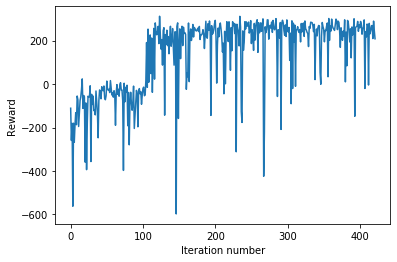

In [52]:
x=list(range(len(traning_score)))
plt.plot(x, traning_score)
plt.xlabel("Iteration number")
plt.ylabel("Reward")
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('trained_model3.h5')

In [53]:
test_games_num = 100
test_scores = []
max_steps_in_game = 1000
for game in range(test_games_num):
    score = 0
    obs = env.reset()  # get initial state
    for step in range(max_steps_in_game):
#         env.render()  # show gif
#         print(observation)  # print state vector 8, fixed for environment
        obs = np.reshape(obs, (1, state_size))
        rewards = trained_model.predict(obs)
        action = int(np.argmax(rewards[0]))
#         action = env.action_space.sample()
        obs, reward, done, info = env.step(action)  # step returns 4 parameters
        score +=reward
        if done:  # game over need reset
#             print("Episode finished after {} timesteps".format(step+1))
            print(score)
            break
    test_scores.append(score)

261.52305692642017
224.59731744477523
278.6214847853836
262.2818942370653
246.73404581636208
236.024354679227
298.2161851785153
249.22241453303286
296.72483068149654
304.72716891940223
253.72392621022001
104.45271941456595
237.7114157463975
287.9872663247868
241.67963162931366
267.29485831928207
247.71436379962984
112.86483469626504
228.59860635460058
280.5367054940144
280.2854219210957
120.91176982978331
274.20244055602063
272.56298011845706
17.65996061062339
231.35800232104788
292.1758581142277
280.58970387508907
302.4633329202942
269.0020976512201
228.85756875400853
258.1466648561084
278.69684278831653
-45.445340550638136
263.51207950808146
229.26136560778488
281.34306238169484
265.052922390276
293.95595949391316
282.7977999271037
266.3095167992674
270.21403343553425
286.662912707435
93.51437200193573
263.6110564089451
131.48728227011003
239.24771151527153
228.1218588670096
142.52834582369132
273.40525973936036
-165.3095552150025
264.91718077657487
-65.05482510267704
246.78489285123

In [54]:
print("Average reward on test 100 games: ", np.mean(test_scores))

Average reward on test 100 games:  230.36902033145947


In [55]:
test_scores = np.array(test_scores)
print("Number of games in 100 where reward")
print("less than 0: ", len(test_scores[test_scores<0]))
print("equals 0: ", len(test_scores[test_scores==0]))
print("more than 0: ", len(test_scores[test_scores>0]))
print("equals or more than 100: ", len(test_scores[test_scores>=100]))
print("equals or more than 200: ", len(test_scores[test_scores>=200]))

Number of games in 100 where reward
less than 0:  5
equals 0:  0
more than 0:  95
equals or more than 100:  93
equals or more than 200:  85
